## 자전거 대여 수요 예측(Bike Sharing Demand)


- [dataset] https://www.kaggle.com/c/bike-sharing-demand
- Overview -> Evaluaton: 성능 평가에 RMSLE 사용
- train.csv 파일로 데이터 분할과 분석/예측 모두 진행

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### 데이터 로드

In [2]:
# bike_demand.csv 파일 불러오기
bike_df = pd.read_csv('bike_demand.csv') # 파일 경로 확인(같은 경로에 위치할 경우 파일명만 입력)

In [3]:
# bike_df 크기 확인
bike_df.shape

(10886, 12)

In [4]:
# 상위 3개 데이터 조회
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


**컬럼 정보** 

datetime : hourly date + timestamp(날짜와 시간)  
season : 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울  
holiday : 1 = 토, 일요일의 주말을 제외한 국경일 등의 휴일, 0 = 휴일이 아닌 날  
workingday : 1 = 토, 일요일의 주말 및 휴일이 아닌 주중, 0 = 주말 및 휴일  
weather:  
• 1 = 맑음, 약간 구름 낀 흐림  
• 2 = 안개, 안개 + 흐림  
• 3 = 가벼운 눈, 가벼운 비 + 천둥  
• 4 = 심한 눈/비, 천둥/번개  
temp : 온도(섭씨)   
atemp : 체감온도(섭씨)  
humidity : 상대습도  
windspeed : 풍속  
casual : 사전에 등록되지 않는 사용자가 대여한 횟수(비회원대여량)  
registered : 사전에 등록된 사용자가 대여한 횟수(회원대여량)  
count : 대여 횟수  

In [5]:
# bike_df 정보 확인(컬럼명, 타입 등)
bike_df.info()

# null 없이 정제된 데이터
# datetime을 제외하면 모두 숫자형 데이터

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


## 데이터 준비

### 컬럼 데이터 타입 변경, 불필요한 컬럼 삭제

In [6]:
# datetime 컬럼의 데이터 타입을 object에서 datetime으로 변경(to_datetime 함수 사용)
bike_df['datetime'] = pd.to_datetime(bike_df['datetime'])

In [7]:
bike_df.info() # 데이터 타입 변경되었는지 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [8]:
# datetime 타입은 object 타입에 비해(추가 코딩 필요) 연, 월, 일, 요일, 시간 등 쉽게 추출 가능
# datetime 컬럼에서 연, 월, 일, 시간 추출
bike_df['year'] = bike_df['datetime'].dt.year
bike_df['month'] = bike_df['datetime'].dt.month
bike_df['day'] = bike_df['datetime'].dt.day
bike_df['hour'] = bike_df['datetime'].dt.hour

In [9]:
# bike_df의 하위 5개 데이터 조회
bike_df.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012,12,19,19
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012,12,19,20
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012,12,19,21
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012,12,19,22
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88,2012,12,19,23


In [10]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  int64         
 13  month       10886 non-null  int64         
 14  day         10886 non-null  int64         
 15  hour        10886 non-null  int64         
dtypes: datetime64[ns](1), 

In [11]:
# 불필요한 컬럼 삭제
drop_columns = ['datetime', 'casual', 'registered'] # 삭제할 컬럼 목록
bike_df = bike_df.drop(drop_columns, axis=1)
# bike_df.drop(drop_columns, axis=1, inplace = True)

In [12]:
bike_df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,4


### 탐색적 데이터분석(EDA) 및 시각화

-  한글폰트 설정
  - [나눔고딕 설치 링크](https://hangeul.naver.com/font) 

In [13]:
plt.rc('font', family='Malgun Gothic')  # Malgun Gothic(windows) / AppleGothic(mac os)
plt.rcParams['figure.figsize'] = (5, 3)
plt.rc('axes', unicode_minus=False)

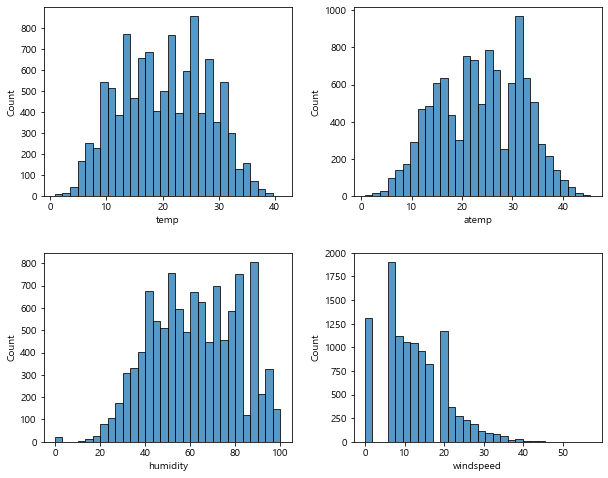

In [14]:
# 기상정보(temp, atemp, humidity, windspeed)의 분포를 히스토그램으로 확인

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# temp
sns.histplot(data=bike_df, x='temp', bins=30, ax=axes[0,0]) # axes[0][0]

# atemp
sns.histplot(data=bike_df, x='atemp', bins=30, ax=axes[0,1]) # axes[0][1]

# humidity
sns.histplot(data=bike_df, x='humidity', bins=30, ax=axes[1,0]) # axes[1][0]

# windspeed
sns.histplot(data=bike_df, x='windspeed', bins=30, ax=axes[1,1]) # axes[1][1]

fig.subplots_adjust(wspace=0.25, hspace=0.3)
# width space, height space: 여러 개의 그래프를 그릴 경우 좌우 간격, 위아래 간격 설정

# 머신러닝 학습 전에 미리 가지고 있는 데이터를 확인하는 작업 필요
# 데이터가 어떤 식으로 분포하는지, 이상치는 없는지 등

#### 박스 플롯(Box plot)
- 5가지 요약수치 : 최솟값, 제1사분위수, 제2사분위수, 제3사분위수, 최댓값
 - 제1사분위수(Q1) : 전체 데이터 중 하위 25%에 해당하는 값
 - 제2사분위수(Q2) : 50%에 해당하는 값(중앙값)
 - 제3사분위수(Q3) : 상위 25%에 해당하는 값
- 사분위 범위수(IQR) : Q3 - Q1
- 최댓값 : Q3 + (1.5 * IQR)
- 최솟값 : Q3 - (1.5 * IQR)
- 이상치 : 최대값보다 큰 값과 최솟값보다 작은 값

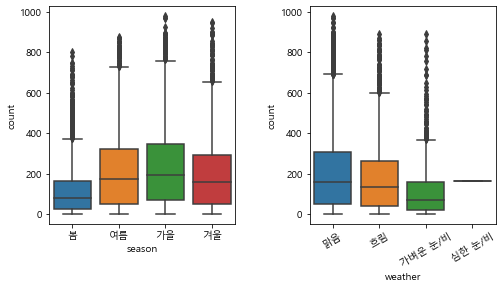

In [15]:
# 계절(season)과 날씨(weather)에 따른 자전거 대여량(count)을 boxplot으로 확인

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# season
sns.boxplot(data=bike_df, x='season', y='count', ax=axes[0]) # axes[0]: 행이 1개이므로 1차원 형식

# weather
sns.boxplot(data=bike_df, x='weather', y='count', ax=axes[1])

axes[0].set(xticklabels=['봄', '여름', '가을', '겨울'])
axes[1].set(xticklabels=['맑음', '흐림', '가벼운 눈/비', '심한 눈/비'])
axes[1].tick_params(axis='x', rotation=30)

fig.subplots_adjust(wspace=0.4)

<AxesSubplot:xlabel='month', ylabel='count'>

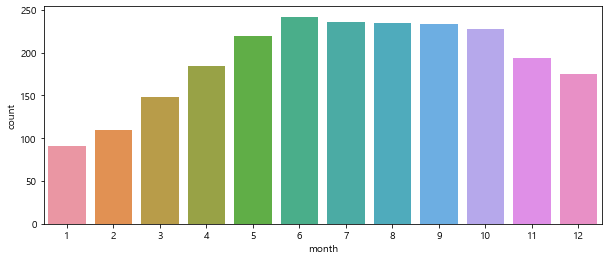

In [16]:
# 월별 대여량을 barplot으로 확인

fig, axes = plt.subplots(figsize=(10, 4))
# 그래프가 1개인 경우 subplots를 사용하지 않아도 되지만 습관적으로 해주면 편함

# barplot 출력
sns.barplot(data=bike_df, x='month', y='count', ci=None)

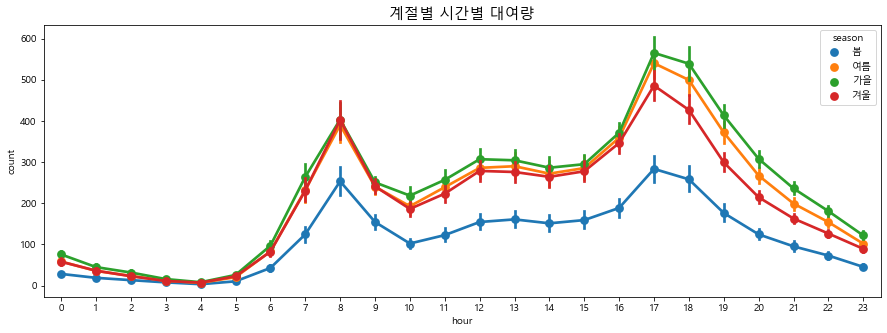

In [17]:
# 계절별, 시간별 대여량을 pointplot으로 확인

fig, ax = plt.subplots(figsize=(15, 5))

# 시간별 대여량을 계절(season)로 색상을 구분하여 출력
g = sns.pointplot(data=bike_df, x='hour', y='count', hue='season')

plt.title('계절별 시간별 대여량', fontsize=15)

# 범례 텍스트 변경: seaborn의 범례 편집 방식(matplotlib에서는 더 간단한 방법 사용)
g.legend_.texts[0].set_text('봄')
g.legend_.texts[1].set_text('여름')
g.legend_.texts[2].set_text('가을')
g.legend_.texts[3].set_text('겨울')

## 모델링

- Evaluation  함수
  - RMSLE(Root Mean Squared Logarithmic Error)  

$\sqrt{(\frac{1}{n})\sum_{i=1}^{n}(log(y_{i}) - log(x_{i}))^{2}}$

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 실데이터와 예측값의 RMSLE를 반환하는 함수
def rmsle(y, pred):
    log_y = np.log1p(y) # 실데이터 로그 변환: log(y)
    log_pred = np.log1p(pred) # 예측값 로그 변환: log(x)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error)) # 최소제곱합의 평균에 루트를 씌우는 과정
    return rmsle


# 로그 변환의 목적:
# 큰 값을 같은 비율의 작은 값으로 변환하여 복잡한 계산을 간단하게 하고,
# 불균형한(한 쪽에 밀집된) 데이터를 고르게 분포하도록 하여 정규성을 높이고 의미있는 결과를 도출

# 로그 변환 시 log()가 아닌 log1p()를 사용하는 이유(log1p(x) = log(x+1)):
# 로그 함수는 (0, 1)의 x 구간, (-∞, 0)의 y 구간을 가지기 때문에,
# x가 0에 가까워지면(x = 0) y가 -inf(음의 무한대) 값을 반환
# 이를 방지하고자 x값에 1을 더하여 음의 무한대인 y값을 0으로 변환

In [19]:
# 학습과 예측에 사용된 모델의 성능을 그래프로 시각화하여 확인하기 위한 함수 생성

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error


# 무작위로 그래프 색상을 선택하기 위한 색상 list
colors = ['b','g','r', 'c', 'm', 'y', 'k', 
          'lightcoral', 'mistyrose', 'tomato', 'darkred', 'sienna',
          'forestgreen', 'royalblue', 'orange', 'lemonchiffon','skyblue',
          'chocolate', 'greenyellow','lime','aqua','lightpink','lightgreen',
          'gold', 'seagreen', 'deepskyblue', 'steelblue', 'slategray']


# 1) plot_pred_actual()
# 실제값과 예측값을 scatter plot으로 보여주는 함수
# 실제값은 'x'로, 예측값은 'o'로 표시하여 어느정도 차이를 보이는지 확인

def plot_pred_actual(pred, actual):
    
    df = pd.DataFrame({'prediction':pred, 'actual':y_test})
    df = df.sort_values(by='actual').reset_index(drop=True)

    plt.figure(figsize=(8, 6))
    plt.scatter(df.index, df['prediction'], marker='x', color='r')
    plt.scatter(df.index, df['actual'], alpha=0.5, marker='o', color='b')
    plt.title('Linear Regression', fontsize=15)
    plt.legend(['prediction', 'actual'], fontsize=12)


# 2) add_rmslevalue()
# 학습/예측을 실행한 모델명을 key로, 예측값과 실데이터의 RMSLE를 value로 predictions에 저장
# predictions에 모델명이 없으면 추가, 이미 존재하면 수정

predictions = {} # 알고리즘의 이름과 RMSLE를 저장할 dictionary

def add_rmslevalue(model_name, pred, actual):
    
    global predictions

    value = rmsle(actual, pred) # 실제값과 예측값의 RMSLE
    predictions[model_name] = value # predictions에 모델 이름과 해당 모델의 RMSLE를 저장


# 3) rmsle_graph()
# predictions에 저장된 모델명과 RMSLE를 그래프(barh)로 나타내는 함수

def rmsle_graph():

    global predictions
    global colors

    eval_value = sorted(predictions.items(), key=lambda x: x[1], reverse=True)
    
    df = pd.DataFrame(eval_value, columns=['model', 'rmsle'])
    print(df)
    min_tick = df['rmsle'].min() - 5
    max_tick = df['rmsle'].max() + 5
    
    fig, axes = plt.subplots(figsize=(10, len(df)))
    axes.set_yticks(np.arange(len(df)))
    axes.set_yticklabels(df['model'], fontsize=15)
    bars = axes.barh(np.arange(len(df)), df['rmsle'])
    
    for i, v in enumerate(df['rmsle']):
        idx = np.random.choice(len(colors)) # 그래프 색상은 colors에서 랜덤 지정
        bars[i].set_color(colors[idx])
        axes.text(v + 1, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')
        
    plt.title('RMSLE ', fontsize=15)
    plt.xlim(0, max_tick)

### 데이터 분할

In [20]:
from sklearn.model_selection import train_test_split

# feature, target 분리
# target: count 컬럼을 y_target에 저장
y_target = bike_df['count']

# feature: count를 제외한 나머지 컬럼을 x_features에 저장
x_features = bike_df.drop(['count'], axis=1)

# 학습/테스트 데이터 분할(test_size 30%)
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target,
                                                   test_size=0.3, random_state=0)

### 모델 훈련: Linear Regression

In [21]:
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error

# LinearRegression 객체 생성
lr_reg = LinearRegression()

# 모델 학습
lr_reg.fit(x_train, y_train)

# 예측값 생성
pred = lr_reg.predict(x_test) 

rmsle_val = rmsle(y_test, pred)
rmse_val = np.sqrt(mean_squared_error(y_test, pred)) # MSE에 루트를 씌워 RMSE 반환

print(f'RMSLE: {rmsle_val:.3f}')
print(f'RMSE: {rmse_val:.3f}')

RMSLE: 1.165
RMSE: 140.900


  model     rmsle
0    LR  1.164664


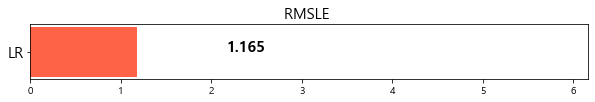

In [22]:
# 모델의 성능(RMSLE) 시각화
add_rmslevalue('LR', pred, y_test)
rmsle_graph()

In [23]:
# 앞서 측정한 모델의 성능값만을 가지고 예측을 얼마나 잘했는지 판단할 수 없음
# 다른 모델과 성능을 비교하거나 실제 데이터를 직접 살펴보며 예측값과 비교해볼 필요가 있음

# 실제 대여횟수(count)와 예측값을 비교하는 데이터프레임 생성
result_df = pd.DataFrame(y_test.values, columns=['real_count']) # 실제 대여횟수 'real_count'
result_df['predicted_count']= np.round(pred) # 대여횟수 예측값 'predicted_count'
result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
# 예측값과 실제값의 차이 'diff'

# 예측값과 실제값의 차이가 가장 큰 데이터부터 내림차순 출력
result_df.sort_values('diff', ascending=False)[:20]

# diff 값이 큰 데이터부터 출력한 결과 실제값과 예측값의 차이가 지나치게 크게 나옴
# 정답 데이터와 예측값의 차이가 클 때 아래 두 가지 작업을 시도:
# 1) 데이터 표준화
# 2) 로그 변환

,real_count,predicted_count,diff
1618,890,322.0,568.0
3151,798,241.0,557.0
966,884,327.0,557.0
412,745,194.0,551.0
2817,856,310.0,546.0
2277,813,267.0,546.0
2314,766,222.0,544.0
454,721,177.0,544.0
1003,713,171.0,542.0
2394,684,142.0,542.0


### 데이터 표준화

In [24]:
bike_df.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'count', 'year', 'month', 'day', 'hour'],
      dtype='object')

In [25]:
data_scaled = pd.DataFrame() # 표준화된 값을 담기 위한 빈 데이터프레임 생성

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # 스케일러 객체 생성

# bike_df.columns -> bike_df의 모든 컬럼에 대한 스케일링 작업 실행
data_scaled[bike_df.columns] = scaler.fit_transform(bike_df[bike_df.columns])

In [27]:
data_scaled

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,-1.349864,-0.17149,-1.460672,-0.660178,-1.333661,-1.092737,0.993213,-1.567754,-0.969294,-1.003866,-1.603121,-1.642070,-1.668944
1,-1.349864,-0.17149,-1.460672,-0.660178,-1.438907,-1.182421,0.941249,-1.567754,-0.836797,-1.003866,-1.603121,-1.642070,-1.524341
2,-1.349864,-0.17149,-1.460672,-0.660178,-1.438907,-1.182421,0.941249,-1.567754,-0.880962,-1.003866,-1.603121,-1.642070,-1.379739
3,-1.349864,-0.17149,-1.460672,-0.660178,-1.333661,-1.092737,0.681430,-1.567754,-0.985856,-1.003866,-1.603121,-1.642070,-1.235137
4,-1.349864,-0.17149,-1.460672,-0.660178,-1.333661,-1.092737,0.681430,-1.567754,-1.052104,-1.003866,-1.603121,-1.642070,-1.090534
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,1.338012,-0.17149,0.684616,-0.660178,-0.596935,-0.467310,-0.617666,1.617227,0.797333,0.996149,1.590639,1.644787,1.078500
10882,1.338012,-0.17149,0.684616,-0.660178,-0.702182,-0.735182,-0.253919,0.269704,0.272866,0.996149,1.590639,1.644787,1.223102
10883,1.338012,-0.17149,0.684616,-0.660178,-0.807428,-0.913959,-0.046064,0.269704,-0.130146,0.996149,1.590639,1.644787,1.367704
10884,1.338012,-0.17149,0.684616,-0.660178,-0.807428,-0.735182,-0.046064,-0.832442,-0.345454,0.996149,1.590639,1.644787,1.512307


In [28]:
# 표준화된 값으로 Linear Regression 수행

# target, feature 분리
y_target = data_scaled['count']
x_features = data_scaled.drop(['count'], axis=1)

# 학습/테스트 데이터 분할(test_size: 30%)
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, 
                                                test_size=0.3, random_state=0) 

In [29]:
from sklearn.linear_model import LinearRegression 

# 모델 객체 생성
lr_reg = LinearRegression()

# 모델 학습
lr_reg.fit(x_train,y_train)

LinearRegression()

In [30]:
# 예측값 생성
pred = lr_reg.predict(x_test) 

rmsle_val = rmsle(y_test, pred)
rmse_val = np.sqrt(mean_squared_error(y_test, pred))

print(f'RMSLE: {rmsle_val:.3f}')
print(f'RMSE: {rmse_val:.3f}')

RMSLE: 1.152
RMSE: 0.778


        model     rmsle
0          LR  1.164664
1  LR(scaled)  1.152455


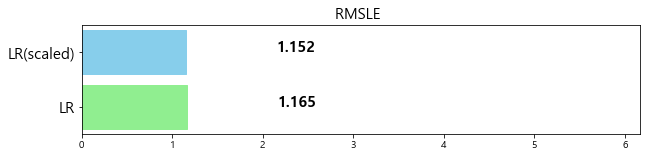

In [41]:
# 모델의 성능(RMSLE) 시각화하여 비교
add_rmslevalue('LR(scaled)', pred, y_test) # 표준화된 RMSLE 값을 predictions에 추가
rmsle_graph()

# 표준화 작업 후 RMSLE 값이 감소

### 로그 변환
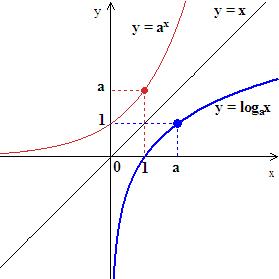
- 로그 함수는 x값이 증가함에 따라 y값이 완만하게 변하는 특성이 있음
- target 데이터의 값을 로그 변환하여 값의 차이를 줄임과 동시에 정규분포화
- 정답 데이터와 예측값의 차이가 큰 경우 target 값을 정규분포형으로 변환하는 작업 시도

In [42]:
from sklearn.model_selection import train_test_split

# target, feature 분리(표준화된 데이터가 아닌 원본 데이터로 진행)
y_target = bike_df['count']
x_features = bike_df.drop(['count'], axis=1)

# 학습/테스트 데이터 분할(test_size: 30%)
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, 
                                                test_size=0.3, random_state=0)

(array([4284., 2337., 1686., 1067.,  633.,  426.,  233.,  116.,   85.,
          19.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <BarContainer object of 10 artists>)

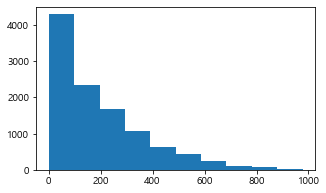

In [47]:
# y_target 값을 히스토그램으로 확인
plt.hist(y_target)

# 한 쪽으로 치우친 불균형한 분포

(array([ 237.,  462.,  625.,  626.,  805., 1076., 1768., 2544., 2058.,
         685.]),
 array([0.69314718, 1.31238343, 1.93161968, 2.55085593, 3.17009218,
        3.78932843, 4.40856467, 5.02780092, 5.64703717, 6.26627342,
        6.88550967]),
 <BarContainer object of 10 artists>)

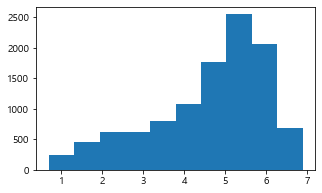

In [48]:
# 로그 변환을 통한 데이터의 정규분포화
y_log_transform = np.log1p(y_target)
plt.hist(y_log_transform)

# 원본 데이터의 한계로 여전히 분포가 아주 고르지는 않지만 로그 변환 후 나아진 모습

In [49]:
# 로그 변환된 target 데이터로 Linear Regression 수행

# target 데이터 로그 변환(log1p 사용)
y_target_log = np.log1p(y_target)

# 로그 변환된 target 데이터를 반영하여 학습/테스트 데이터 분할
x_train, x_test, y_train, y_test =  train_test_split(x_features, y_target_log,
                                                    test_size=0.3, random_state=0)

In [50]:
# 모델 객체 생성, 모델 학습, 예측값 생성
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)
pred = lr_reg.predict(x_test)

# target 데이터가 전체적으로 로그 변환된 상태(y_train, y_test)
# 로그 변환된 y_test와 로그 변환된 값을 기반으로 학습/예측을 수행한 pred를 원래 scale로 변환
# 예측값과 실제값의 비교는 로그 변환 이전의 상태에서 진행
# exp(): 지수 함수
# expm1(x) = exp(x)-1 이지만, expm1()가 더 높은 정확도 제공
y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)     

rmsle_val = rmsle(y_test_exp, pred_exp)
rmse_val = np.sqrt(mean_squared_error(y_test_exp, pred_exp))
print(f'RMSLE: {rmsle_val:.3f}')
print(f'RMSE: {rmse_val:.3f}')


RMSLE: 1.017
RMSE: 162.594


               model     rmsle
0                 LR  1.164664
1         LR(scaled)  1.152455
2  LR(log transform)  1.016827


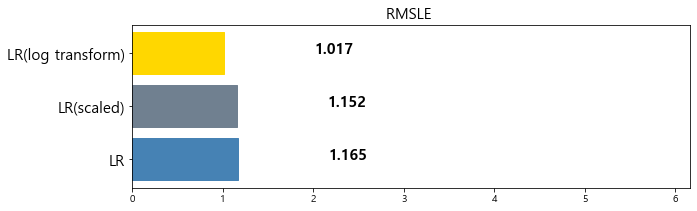

In [58]:
add_rmslevalue('LR(log transform)', pred_exp, y_test_exp) # 로그 변환된 RMSLE 값을 추가
rmsle_graph()

# 자전거 대여 데이터의 경우 로그 변환 모델의 성능이 가장 우수함
# 어떤 데이터를 가지고 있는지에 따라 성능이 좋은 모델도 달라지므로,
# 다양한 시도를 해보는 것이 중요 -> 상대적으로 높은 예측 정확도를 보이는 모델을 선택

### 회귀계수 시각화

In [59]:
# lr_reg.coef_를 Series로 생성(가장 성능이 좋았던 log transform 모델 사용)
coef = pd.Series(lr_reg.coef_, index=x_features.columns)

# 회귀계수 값 내림차순 정렬
coef_sort = coef.sort_values(ascending=False)
coef_sort

# 숫자값이 values, 컬럼명이 index

year          0.418513
hour          0.098348
month         0.076839
atemp         0.030857
temp          0.011712
windspeed     0.003961
day           0.003353
humidity     -0.014512
weather      -0.014733
season       -0.044525
holiday      -0.046010
workingday   -0.066383
dtype: float64

<AxesSubplot:>

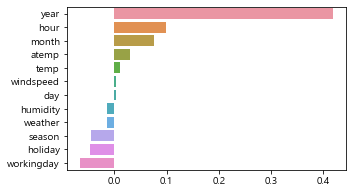

In [62]:
# coef_sort 값을 수평 barplot으로 시각화하여 표현
sns.barplot(x=coef_sort.values, y=coef_sort.index)

# year 변수의 경우 2011, 2012로 값이 크다보니 상대적으로 회귀계수가 크게 도출
# year, month, hour 변수는 숫자 데이터이지만 사실상 범주형 데이터에 해당
# 숫자로서의 의미를 가지지 않는 숫자 데이터가 회귀계수에 영향을 미치지 않도록 데이터 인코딩

### 데이터 인코딩

In [63]:
# 범주형 데이터를 대상으로 One Hot Encoding
# 회귀 모델은 숫자에 영향을 받으므로 Label Encoding이 아닌 One Hot Encoding
x_features_ohe = pd.get_dummies(x_features, columns=['year', 'month', 'hour', 'holiday',
                                              'workingday', 'season', 'weather'])

In [64]:
x_features_ohe

,temp,atemp,humidity,windspeed,day,year_2011,year_2012,month_1,month_2,month_3,...,workingday_0,workingday_1,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,9.84,14.395,81,0.0000,1,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
1,9.02,13.635,80,0.0000,1,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
2,9.02,13.635,80,0.0000,1,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
3,9.84,14.395,75,0.0000,1,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
4,9.84,14.395,75,0.0000,1,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,15.58,19.695,50,26.0027,19,0,1,0,0,0,...,0,1,0,0,0,1,1,0,0,0
10882,14.76,17.425,57,15.0013,19,0,1,0,0,0,...,0,1,0,0,0,1,1,0,0,0
10883,13.94,15.910,61,15.0013,19,0,1,0,0,0,...,0,1,0,0,0,1,1,0,0,0
10884,13.94,17.425,61,6.0032,19,0,1,0,0,0,...,0,1,0,0,0,1,1,0,0,0


In [66]:
# 범주형 feature 인코딩 후 학습/테스트 데이터 분할
x_train, x_test, y_train, y_test =  train_test_split(x_features_ohe, y_target,
                                                    test_size=0.3, random_state=0)

# 이거 다시 넣는 부분 이후의 녹강 확인(4교시 37분 정도) -> 4교시 녹강 끝까지 확인

               model     rmsle
0                 LR  1.164664
1         LR(scaled)  1.152455
2  LR(log transform)  1.016827
3    Ridge(alpha=10)  0.842213


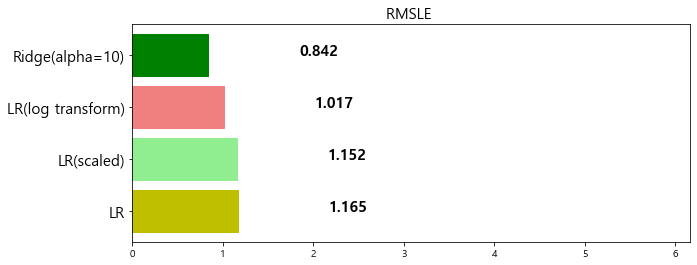

In [67]:
from sklearn.linear_model import Ridge

# Ridge 모델 객체 생성(alpha=10), 모델 학습, 예측값 생성
# 규제 선형 회귀 모델의 alpha 값은 항상 임의로 지정
# 특별한 기준 없이 데이터마다 좋은 성능을 내는 값이 천차만별이므로,
# 여러 개의 하이퍼 파라미터를 시도해보는 것이 좋음
ridge = Ridge(alpha=10)
ridge.fit(x_train, y_train)
pred = ridge.predict(x_test)

# predictions에 모델 추가 및 성능 지표 시각화
add_rmslevalue('Ridge(alpha=10)', pred, y_test)
rmsle_graph()

                model     rmsle
0                  LR  1.164664
1          LR(scaled)  1.152455
2   LR(log transform)  1.016827
3     Ridge(alpha=10)  0.842213
4  Lasso(alpha=0.001)  0.818387


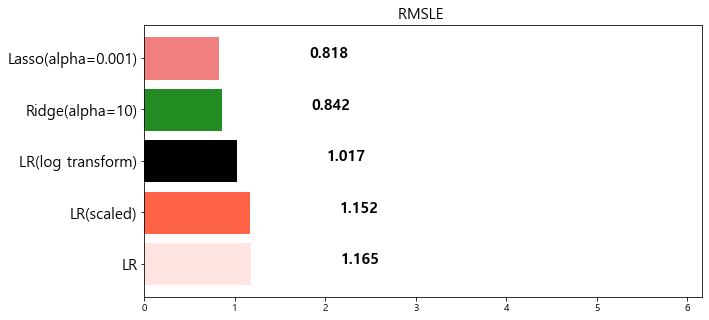

In [68]:
from sklearn.linear_model import Lasso

# Lasso 모델 객체 생성(alpha=0.001), 모델 학습, 예측값 생성
lasso = Lasso(alpha=0.001)
lasso.fit(x_train, y_train)
pred = lasso.predict(x_test)

# predictions에 모델 추가 및 성능 지표 시각화
add_rmslevalue('Lasso(alpha=0.001)',pred, y_test)
rmsle_graph()

                   model     rmsle
0                     LR  1.164664
1             LR(scaled)  1.152455
2      LR(log transform)  1.016827
3        Ridge(alpha=10)  0.842213
4     Lasso(alpha=0.001)  0.818387
5  RandomForestRegressor  0.496289


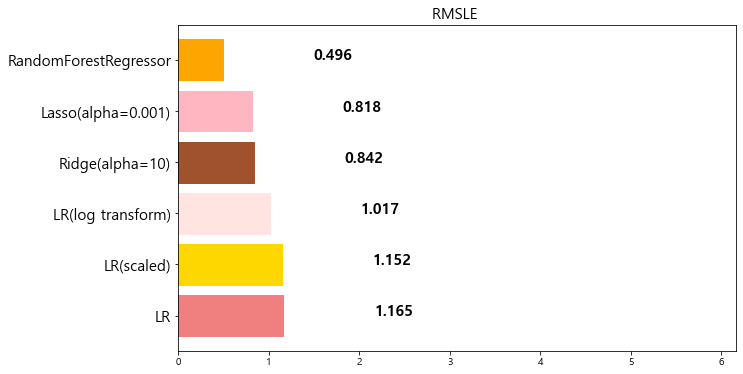

In [77]:
from sklearn.ensemble import RandomForestRegressor

# 분류, 회귀가 모두 가능한 RandomForest 모델(이후에 자세히 다룰 예정)
rfr = RandomForestRegressor()
rfr.fit(x_train, y_train)
pred = rfr.predict(x_test)

# predictions에 모델 추가 및 성능 지표 시각화
add_rmslevalue('RandomForestRegressor', pred, y_test)
rmsle_graph()

# 대부분의 경우 RandomForest 모델의 성능이 가장 우수할 것

In [78]:
# predictions 내용 삭제
predictions.clear() 